# Install required packages for python 3.10

In [ ]:
!pip install pandas=="2.1.4" lightgbm=="4.2.0" pyarrow=="14.0.2" seaborn=="0.13.2"

# Download datasets into 'Downloads Folder'

In [ ]:
!wget https://static.mlalpha.com/public-datasets/ml-public-to-predict-v3.parquet
!wget https://static.mlalpha.com/public-datasets/ml-public-train-v3.parquet
!wget https://static.mlalpha.com/public-datasets/ml-public-test-app-v3.parquet

In [1]:
from lightgbm import LGBMRegressor
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os

### Choose the features and the target for training. Here is an example choosing "2W" performance targets
The names of the features are encoded to protect our dataset's intellectual property. However, we provide an indication of what the features entail. Here are some properties:

**Fundamental:**

Anything related to the company's financial report is prefixed by `fund_`.
- `ratio` indicates that the feature depends on the stock price or some fundamental multiple.
- `growth` indicates the variation of the fundamental feature. The timeframe follows growth.

**Technical:**

Technical aspects, prefixed with `tec_`, are features dependent solely on price. They can be:
- `indicator` for technical indicators like RSI, Stochastic, ATR...
- `distance` represents a percentage change compared to a reference point.
- `vs-market` is a ratio of the feature compared to the market.
- `volatility-adjusted` takes into consideration volatility.
- `change` indicates a percentage change of the technical feature over a specified period.

You may encounter a timeframe, e.g., `short-term`, indicating that the feature is calibrated over a short-term evaluation. When prefixed with `change`, it indicates the variation of the same feature over the mentioned period.


In [30]:
FEATURES = [
    'fund_e2eec',
    'fund_ratio_db72a',
    'fund_ratio_cd4da',
    'fund_ratio_14908',
    'fund_ratio_3039d',
    'fund_ratio_f1458',
    'fund_growth-since-last_18674',
    'tec_distance_volatility-adjusted_30692',
    'tec_short-term_a94f1',
    'tec_vs-market_indicator_short-term_d65fd',
    'tec_change-very-short-term_indicator_short-term_39a28',
    'tec_change-short-term_short-term_155d3',
    'tec_distance_indicator_very-long-term_3ab87',
    'tec_change-very-short-term_distance_indicator_short-term_e84de',
    'tec_change-very-short-term_distance_indicator_short-term_7c965',
    'tec_change-short-term_distance_indicator_very-long-term_943ec',
    'tec_vs-market_short-term_3e059',
    'tec_distance_volatility-adjusted_long-term_d95df',
    'tec_change-very-short-term_indicator_mid-long-term_73495',
    'tec_change-very-short-term_indicator_long-term_783ed'
]

TARGET = 'target_2W'


## Load datasets

### Load datasets into python DataFrame

In [33]:
df_train = pd.read_parquet('ml-public-train-v3.parquet', engine='pyarrow', columns=['era', 'security_by_time', TARGET] + FEATURES)
df_test = pd.read_parquet('ml-public-test-app-v3.parquet', engine='pyarrow', columns=['security_by_time'] + FEATURES)
df_to_predict = pd.read_parquet('ml-public-to-predict-v3.parquet', engine='pyarrow', columns=['security_by_time'] + FEATURES)

## Explore the data

In [34]:
df_train.describe()

,era,target_2W,fund_e2eec,fund_ratio_db72a,fund_ratio_cd4da,fund_ratio_14908,fund_ratio_3039d,fund_ratio_f1458,fund_growth-since-last_18674,tec_distance_volatility-adjusted_30692,...,tec_change-very-short-term_indicator_short-term_39a28,tec_change-short-term_short-term_155d3,tec_distance_indicator_very-long-term_3ab87,tec_change-very-short-term_distance_indicator_short-term_e84de,tec_change-very-short-term_distance_indicator_short-term_7c965,tec_change-short-term_distance_indicator_very-long-term_943ec,tec_vs-market_short-term_3e059,tec_distance_volatility-adjusted_long-term_d95df,tec_change-very-short-term_indicator_mid-long-term_73495,tec_change-very-short-term_indicator_long-term_783ed
count,8.213000e+05,819402.000000,821300.000000,795786.000000,740686.000000,773121.000000,782630.000000,821300.000000,757793.000000,809557.000000,...,816969.000000,820494.000000,662538.000000,811267.000000,816783.000000,660326.000000,817479.000000,774507.000000,800838.000000,782833.000000
mean,1.746414e+06,0.500578,0.500929,0.497681,0.502062,0.500223,0.503492,0.502955,0.500201,0.499575,...,0.496773,0.498246,0.498330,0.495281,0.496931,0.499781,0.502231,0.498579,0.495690,0.498613
std,4.851020e+05,0.288676,0.288256,0.288183,0.289628,0.288963,0.289215,0.287712,0.286882,0.287183,...,0.290233,0.286907,0.288860,0.289222,0.289811,0.289553,0.287913,0.287020,0.289605,0.287593
min,3.022750e+05,0.000371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.433970e+06,0.250587,0.253221,0.244679,0.255791,0.249422,0.250624,0.256851,0.256634,0.251062,...,0.242339,0.249701,0.249398,0.244153,0.245873,0.248756,0.254115,0.250146,0.243727,0.250843
50%,1.871280e+06,0.500521,0.500063,0.497729,0.498726,0.493913,0.504652,0.506857,0.499430,0.501244,...,0.496027,0.496060,0.500060,0.492885,0.495459,0.500248,0.508144,0.498291,0.491881,0.495897
75%,2.154910e+06,0.750577,0.751653,0.747037,0.756053,0.753802,0.753296,0.751384,0.748696,0.745251,...,0.748244,0.745036,0.747482,0.744016,0.750982,0.751356,0.749362,0.742384,0.746179,0.744805
max,2.345315e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='tec_change-short-term_short-term_155d3', ylabel='Count'>

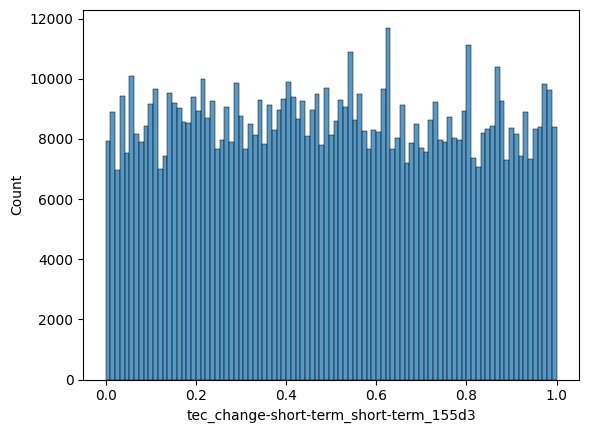

In [35]:
sns.histplot(df_train['tec_change-short-term_short-term_155d3'])

In [36]:
df_train.isna().count()

era                                                               821300
security_by_time                                                  821300
target_2W                                                         821300
fund_e2eec                                                        821300
fund_ratio_db72a                                                  821300
fund_ratio_cd4da                                                  821300
fund_ratio_14908                                                  821300
fund_ratio_3039d                                                  821300
fund_ratio_f1458                                                  821300
fund_growth-since-last_18674                                      821300
tec_distance_volatility-adjusted_30692                            821300
tec_short-term_a94f1                                              821300
tec_vs-market_indicator_short-term_d65fd                          821300
tec_change-very-short-term_indicator_short-term_39a

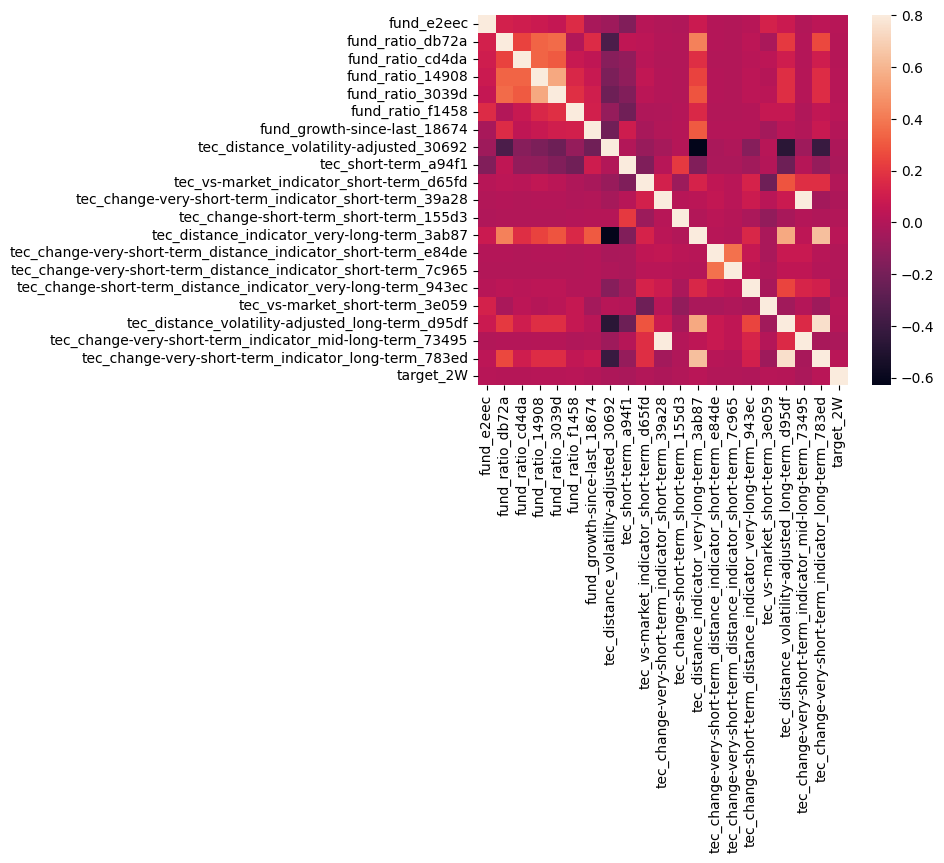

In [37]:
corrmat = df_train[FEATURES + [TARGET]].corr()
sns.heatmap(corrmat, vmax=.8, square=True);

# Machine Learning

**Before training and testing we need to do something with the NaN values**

In [38]:
# Simple NaN Fix, feel free to bring your own creativity!
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

**Further split the training dataset into a train (df_train_train) and a test (df_train_test) datasets**

In [39]:
# This value represents the 3rd quartile of the dataset.
# IMPORTANT TIP: do not use 'train_test_split' from sklearn directly as it is important to keep training eras in past and testing eras in the future to ensure realistic performance tests
q3_era = 2.111405e+06
df_train_train = df_train[df_train.era <= q3_era] 
df_train_test = df_train[df_train.era > q3_era] 

# Extract features and target variables
X = df_train_train[FEATURES].values
y = df_train_train[TARGET].values

For our example and within ML Alpha, we opted for LightGBM due to its superior performance and speed. 

Additionally, alternatives such as XGBRegressor or RandomForestRegressor are viable options.


In [40]:
# Define model configuration. Here we picked LGBMRegressor!
model_conf = dict(
    deterministic=True,
    seed=0,
    metric='rmse',
    learning_rate=0.05,
    n_estimators=800,
    feature_fraction=0.1,
    bagging_fraction=0.3,
    bagging_freq=5,
    verbose=-1
)

model_train = LGBMRegressor(**model_conf)

#And train the model with the selected features in X and targets in y
print('Train Model on test test dataset')
model_train.fit(X, y)

Train Model on test test dataset


LGBMRegressor(bagging_fraction=0.3, bagging_freq=5, deterministic=True,
              feature_fraction=0.1, learning_rate=0.05, metric='rmse',
              n_estimators=800, seed=0, verbose=-1)

**Now let's evaluate the model testing its performance on the df_test_train dataset**

In [41]:
# Generate predictions for the test dataset
y_pred_test = model_train.predict(df_train_test[FEATURES].values)
df_train_test.loc[:, 'predicted_value'] = y_pred_test

/var/folders/wd/rrzm8kh12j31ht7dv4r9nc580000gn/T/ipykernel_85690/2045457703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test.loc[:, 'predicted_value'] = y_pred_test


In [42]:
target = df_train_test[TARGET]
preds = df_train_test['predicted_value']

# Calculate performance metrics
mse = ((target - preds)**2).mean()
rmse = ((target - preds) ** 2).mean() ** .5
corr = target.corr(preds)
mae = (target - preds).abs().mean()

y_mean = target.mean()
ss_total = ((target - y_mean)**2).sum()
ss_residual = ((target - preds)**2).sum()
r2 = 1 - (ss_residual / ss_total)

dict(mse=mse, rmse=rmse, corr=corr, mae=mae, r2=r2)

{'mse': 0.08339690347033864,
 'rmse': 0.28878522031146026,
 'corr': 0.056925931487653465,
 'mae': 0.24989204337102403,
 'r2': 0.0023571770785022483}

## Generate predictions for the Test Dataset and submit them to ML Alpha for backtesting
To get a feel for how well your model is working in the real world, we have reserved a period of market history to backtest it and assess how well your model would have performed following a periodic rebalance strategy at the chosen rebalance period

*Note that the "FEATURES" variable must be the same list (i.e. exact same features) that you selected a training time of your model. 
The variable "model" is your model already trained and ready for inference.*

In [43]:

model = LGBMRegressor(**model_conf)

X = df_train[FEATURES].values
y = df_train[TARGET].values

print('Train Model on full test dataset')
model.fit(X, y)

Train Model on full test dataset


LGBMRegressor(bagging_fraction=0.3, bagging_freq=5, deterministic=True,
              feature_fraction=0.1, learning_rate=0.05, metric='rmse',
              n_estimators=800, seed=0, verbose=-1)

## Generate predictions for the test dataset

In [44]:
print('Predict on test')
y_pred = model.predict(df_test[FEATURES].values)
df_test.loc[:, 'predicted_value'] = y_pred

Predict on test


## Evaluate predictions over the test dataset
This API call is designed to provide performance metrics for your model based on data that may not be accessible through your portfolio. It is important to exercise caution to prevent overfitting your predictions to the test data, as this can potentially lead to suboptimal real-world results.

**Get Your API Key from your [ML Alpha profile](https://app.mlalpha.com/profile)**

In [45]:
api_key = 'j18Www2kE67tr3jl1TB6Iq2gQc9p1eQU' #this key is deactivated

### Submit predictions for the test dataset

performce metrics: mse=0.08741383437005033, rmse=0.29565830678343935, corr=0.032872834651884356, mae=0.2578007929876922, r2=-0.008422083192496155

The portfolio based on the output of the machine learning algorithm has made the following performance
Portfolio: CARG: 4.83%, total return: 11.18%, sharpe ratio: 0.33, max drawdown: -21.55%
S&P500: CARG: 4.16%, total return: 9.59%, sharpe ratio: 0.31, max drawdown: -24.32%


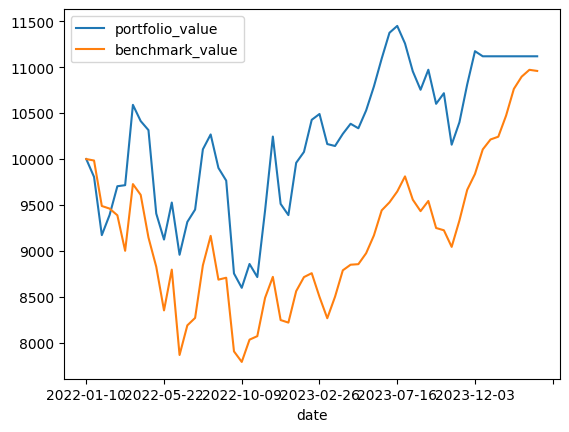

In [46]:
model_data = dict(security_by_time=df_test['security_by_time'].to_list(), target=TARGET, values=df_test['predicted_value'].to_list(), api_key=api_key)
r = requests.post('https://api.mlalpha.com/v0.1/mlds/benchmark_test_ds', json=model_data, headers={'Content-Type': 'application/json'})

if r.status_code == 200:
  data = r.json()
  print(f'performce metrics: mse={data["mse"]}, rmse={data["rmse"]}, corr={data["corr"]}, mae={data["mae"]}, r2={data["r2"]}')

  print('')
  print(f'The portfolio based on the output of the machine learning algorithm has made the following performance')
  print(f"Portfolio: CARG: {data['periodCAGR']}%, total return: {data['periodCumulativeReturn']}%, sharpe ratio: {data['periodSharpe']}, max drawdown: {data['periodMaxDrawdown']}%")
  print(f"S&P500: CARG: {data['periodCAGRBench']}%, total return: {data['periodCumulativeReturnBench']}%, sharpe ratio: {data['periodSharpeBench']}, max drawdown: {data['periodMaxDrawdownBench']}%")


  df_perf = pd.DataFrame({'date': data['periodPortfolioValuePlot']['dates'], 'portfolio_value': data['periodPortfolioValuePlot']['prices'], 'benchmark_value': data['periodPortfolioValuePlot']['benchmarkPrices']})
  df_perf.set_index('date').plot()
else:
  print(f'ERROR when calling the MLALPHA API (error code: {r.status_code}) if 401 is the error code, make sure you are logged-in correctly and the token is passed in the headers, if 500 please contact us and tell us the time of the error ({datetime.now()})')

Hmm, the correlation appears to be only 0.0328, indicating a relatively modest result. However, I have confidence that you can enhance it further! Enjoy!

## Submitting Biweekly Predictions

We generate new data every two weeks, and you can receive notifications either via email or through the [ML Alpha web portal](https://app.mlalpha.com).

Once you are satisfied with your model, you can upload predictions to your Data Science Portfolio based on your target:

- `target_2W`: Biweekly predictions
- `target_1M`: Monthly predictions
- `target_1Q`: Quarterly predictions

After submitting your predictions, please allow for the completion of the current period before submitting new ones.

[Be sure to check out our article on creating a data science portfolio](https://mlalpha.com/2024/01/16/how-to-upload-predictions-to-ml-alpha/?swcfpc=1).


## Submit Your Predictions to Your Data Science Portfolio

Every two weeks, new data is generated. You can opt to receive notifications either via email or through the [ML Alpha web portal](https://app.mlalpha.com).
Once you are satisfied with your model, feel free to upload predictions to your Data Science Portfolio according to your target:


In [17]:
print('Predict on current')
y_pred_current = model.predict(df_to_predict[FEATURES].values)
df_to_predict['predicted_value'] = y_pred_current

Predict on current


Retrieve the required information from [ML Alpha Portfolios](https://app.mlalpha.com/my-portfolios) by selecting your Datasicene portfolio.

In [18]:
PORTFOLIO_ID=52

In [20]:
model_data = dict(
  portfolio_id=PORTFOLIO_ID, 
  security_by_time=df_to_predict['security_by_time'].to_list(), 
  target=TARGET, 
  values=df_to_predict['predicted_value'].to_list(), 
  api_key=api_key
)

r = requests.post('https://api.mlalpha.com/v0.1/mlds/submit_predictions', json=model_data, headers={'Content-Type': 'application/json'})
data = r.json()

if r.status_code == 200:
  print('Predictions have been submitted! Good Luck!')
  print(f'stocks predicted: {data["predicted_symbols"]}')
else:
  print(f'It looks like there is an error {r.status_code}: {data["msg"]}')

Predictions have been submitted! Good Luck!
stocks predicted: ['TY', 'TCN', 'FICO', 'NGL', 'QLYS', 'MCO', 'MAS', 'HLNE', 'SBAC', 'NFJ', 'COOP', 'KRC', 'MYO', 'GRND', 'INTU']
